# Iterative phase estimation
Quantum phase estimation (QPE) is a central building block for many quantum algorithms, most famously Shor's algorithm for factoring and the HHL algorithm for solving linear systems of equations on a quantum computer. In this notebook, we implement the iterative phase estimation (IPE) algorithm, an implementation of QPE, described in Ref [1] and [2]. 

In this notebook, two qubits are used, with the 0th qubit being the ancilla qubit and the 1st qubit being the data qubit. The phase oracle in this example uses an ancilla qubit to add a phase $e^{i\phi}$ to the $|1\rangle$ component of the state of the data qubit. The oracle is written as a subroutine that will be used by the quantum program. 

In [1]:
# general imports
import math
from collections import Counter
import matplotlib.pyplot as plt

# AWS imports: Import Braket SDK modules
from braket.devices.local_simulator import LocalSimulator
import braket.experimental.autoqasm as aq
from braket.experimental.autoqasm.instructions import measure, x, rz, h, cphaseshift, reset

The phase in the oracle is defined by `phase` in the subroutine which is assumed to be unknown to the IPE algorithm. In this example, the phase is 3/16, which is 0.0011 in the binary fraction representation.

In [2]:
@aq.subroutine
def phase_oracle(ancilla_qubit: int, data_qubit: int) -> None:
    """Phase oracle that applies phase oracle on q1
    conditioned on q0.

    Args:
        ancilla_qubit (int): qubit that control adding phase to data qubit
        data_qubit (int): qubit that the phase is added to
    """
    phase = 2 * math.pi * (3 / 16)
    cphaseshift(ancilla_qubit, data_qubit, phase)

The algorithm starts by preparing the data qubit (i.e., qubit 1) in an eigenstate of the oracle. Because the oracle in this example is the phase shift operation, the eigenstates are computational basis states (i.e., $|0\rangle$ and $|1\rangle$), and the oracle only applies non-trivially on $|1\rangle$ of the data qubit. We choose $|1\rangle$ to be the starting state of qubit 1. 

Each iteration estimates a precision digit, in binary fraction representation of the phase, starting from the smallest digit. There are four steps in an iteration:

1. Preparing a superposition state, $|0\rangle+|1\rangle$, on the ancilla qubit. The algorithm uses the relative phase between $|0\rangle$ and $|1\rangle$ for computation.

2. Except for the first iteration, apply a phase offset to the ancilla which offsets the phases estimated by previous iterations in order to yield a more accurate estimation for larger digits. This step corresponds to the Z gate in Fig. 1 of Ref [1]. 

3. Apply the phase oracle on the data and ancilla qubits by a number of times, depending on the iteration. 

4. Measure ancilla qubit to get the phase estimate. The measurement outcome $c$ in iteration $i$ means that the phase estimate for that iteration is $2\pi c/2^{i}$.

In [3]:
# TODO: consider using n_iterations as an input (blocked by #818)
n_iterations = 4

@aq.main(num_qubits=2)
def ipe():
    """Iterative phase estimation algorithm."""
    q_ancilla = 0
    q_data = 1

    c = aq.BitVar(0)
    b0 = aq.BitVar(size=n_iterations)

    # Prepare an eigenstate of the oracle on the data qubit.
    x(q_data)

    for iteration in aq.range(n_iterations):
        # 1. Prepare superposition on the ancilla qubit
        h(q_ancilla)

        # 2. Apply phase offset
        if iteration > 0:
            for i in aq.range(iteration):
                k = b0[i]
                if k:
                    rz(q_ancilla, -2 * math.pi / 2 ** (iteration + 1 - i))

        # 3. Apply phase oracle
        n_oracle = 2 ** (n_iterations - 1 - iteration)
        for j in aq.range(n_oracle):
            phase_oracle(q_ancilla, q_data)

        # 4. Measure on the ancilla qubit in X basis
        h(q_ancilla)
        c = measure(q_ancilla)
        b0[iteration] = c

        reset(q_ancilla)

Let's execute the IPE algorithm on the Braket simulator.

measurement counts:  Counter({'1100': 100})


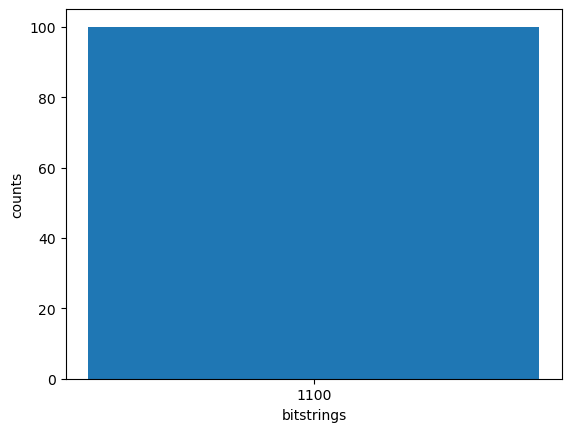

In [4]:
device = LocalSimulator()
result = device.run(ipe, shots=100).result()
counts = Counter(result.measurements["b0"])
print("measurement counts: ", counts)

plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.show()

The measurement results of the IPE algorithm are "1100" in all shots, which is equivalent to 0.0011 in binary fraction or 3/16. We have correctly estimated the phase in the oracle! 

## Summary
In this notebook, we walked you through all stages of executing the IPE algorithm, from constructing a subroutine for the phase oracle, composing the dynamic circuit in the main IPE program, running the quantum program on the Braket simulator to visualizing the results. AutoQASM not only provides expressibility of classical control flow which enables a broader class of quantum programs, it also integrates with Amazon Braket which provides an end-to-end experience for a quantum algorithm.


### References:

[1] K. M. Svore et al., *Faster Phase Estimation* (2013). arXiv: https://arxiv.org/abs/1304.0741

[2] A. D. Corcoles et al., *Exploiting dynamic quantum circuits in a quantum algorithm with superconducting qubits* (2021). arXiv: https://arxiv.org/abs/2102.01682